,datetime_utc,volume_demand,volume_production,spot_price,coal_price,crude_oil_price,natural_gas_price,hydro_level,precipitation,max_temp,avg_temp,min_temp,max_wind,max_gust,avg_wind,snow_depth,hour,day_of_week,is_weekend,month,year,day_of_year,week_of_year,is_peak_hour,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,spot_price_lag_1h,spot_price_lag_24h,spot_price_lag_48h,spot_price_lag_72h,spot_price_lag_168h,volume_demand_lag_1h,volume_demand_lag_24h,volume_demand_lag_48h,volume_demand_lag_72h,volume_demand_lag_168h,volume_production_lag_1h,volume_production_lag_24h,volume_production_lag_48h,volume_production_lag_72h,volume_production_lag_168h,spot_price_rolling_mean_24h,spot_price_rolling_std_24h,spot_price_rolling_mean_168h,spot_price_rolling_std_168h,volume_demand_rolling_mean_24h,volume_demand_rolling_std_24h,volume_demand_rolling_mean_168h,volume_demand_rolling_std_168h,volume_production_rolling_mean_24h,volume_production_rolling_std_24h,volume_production_rolling_mean_168h,volume_production_rolling_std_168h,price_change_24h,price_change_168h,days_since_start,demand_production_ratio,returns,volatility_24h,price_ewma,hour_weekend_interaction,demand_production_interaction,yearly_sin,yearly_cos
168,2016-01-07 23:00:00,5018.0,7513.0,21.06,47.206250,31.749167,2.465000,0.846752,1.000000,-2.000000,-4.083333,-1.0,14.0,25.000000,9.0,20.916667,23,3,0,1,2016,7,1,0,-0.258819,0.965926,0.433884,-0.900969,0.5,0.866025,20.26,21.94,20.02,17.68,16.39,5280.0,5089.0,4951.0,4893.0,4043.0,8698.0,9169.0,9023.0,8698.0,7818.0,23.947500,3.172842,19.476429,4.693194,5671.375000,437.501981,5134.101190,621.786336,9228.000000,441.291977,8655.517857,1102.550994,-0.88,4.67,7.000000,0.667909,0.039487,0.071118,23.486380,0,37700234.0,0.120126,0.992759
169,2016-01-08 00:00:00,4917.0,7161.0,20.16,47.150000,31.670000,2.470000,0.846436,1.000000,-2.000000,-4.000000,-1.0,14.0,25.000000,9.0,21.000000,0,4,0,1,2016,8,1,0,0.000000,1.000000,-0.433884,-0.900969,0.5,0.866025,21.06,21.75,19.63,17.33,16.04,5018.0,5018.0,4879.0,4813.0,4010.0,7513.0,9165.0,9199.0,8688.0,7694.0,23.881250,3.236679,19.500952,4.685889,5667.166667,444.490002,5139.500000,615.877155,9144.500000,610.779046,8652.345238,1106.095517,-1.59,4.12,7.041667,0.686636,-0.042735,0.071648,23.220270,0,35210637.0,0.137185,0.990545
170,2016-01-08 01:00:00,4898.0,7052.0,19.78,47.143750,31.648750,2.470972,0.846120,1.000000,-2.041667,-4.000000,-1.0,14.0,24.666667,9.0,21.104167,1,4,0,1,2016,8,1,0,0.258819,0.965926,-0.433884,-0.900969,0.5,0.866025,20.16,21.50,19.33,17.24,15.74,4917.0,4967.0,4857.0,4809.0,3930.0,7161.0,9073.0,9142.0,8652.0,7437.0,23.809583,3.309911,19.525000,4.676830,5664.291667,449.411546,5145.261905,608.983321,9060.291667,745.520914,8650.053571,1109.023567,-1.72,4.04,7.083333,0.694555,-0.018849,0.071711,22.945048,0,34540696.0,0.137185,0.990545
171,2016-01-08 02:00:00,4925.0,6884.0,19.38,47.137500,31.627500,2.471944,0.845805,1.000000,-2.083333,-4.000000,-1.0,14.0,24.333333,9.0,21.208333,2,4,0,1,2016,8,1,0,0.500000,0.866025,-0.433884,-0.900969,0.5,0.866025,19.78,21.52,19.35,17.32,15.57,4898.0,4947.0,4829.0,4790.0,3839.0,7052.0,8991.0,9107.0,8618.0,7120.0,23.720417,3.401821,19.547679,4.666764,5663.375000,450.957996,5151.726190,600.742601,8972.500000,868.028751,8648.648810,1111.120722,-2.14,3.81,7.125000,0.715427,-0.020222,0.071814,22.659844,0,33903700.0,0.137185,0.990545
172,2016-01-08 03:00:00,4932.0,6534.0,18.61,47.131250,31.606250,2.472917,0.845489,1.000000,-2.125000,-4.000000,-1.0,14.0,24.000000,9.0,21.312500,3,4,0,1,2016,8,1,0,0.707107,0.707107,-0.433884,-0.900969,0.5,0.866025,19.38,21.60,19.51,17.66,15.47,4925.0,4995.0,4876.0,4833.0,3833.0,6884.0,9068.0,9117.0,8642.0,7041.0,23.595833,3.534996,19.566369,4.656611,5660.750000,455.181306,5158.267857,592.219822,8866.916667,999.989431,8645.630952,1116.190273,-2.99,3.14,7.166667,0.754821,-0.039732,0.072208,22.335857,0,32225688.0,0.137185,0.990545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

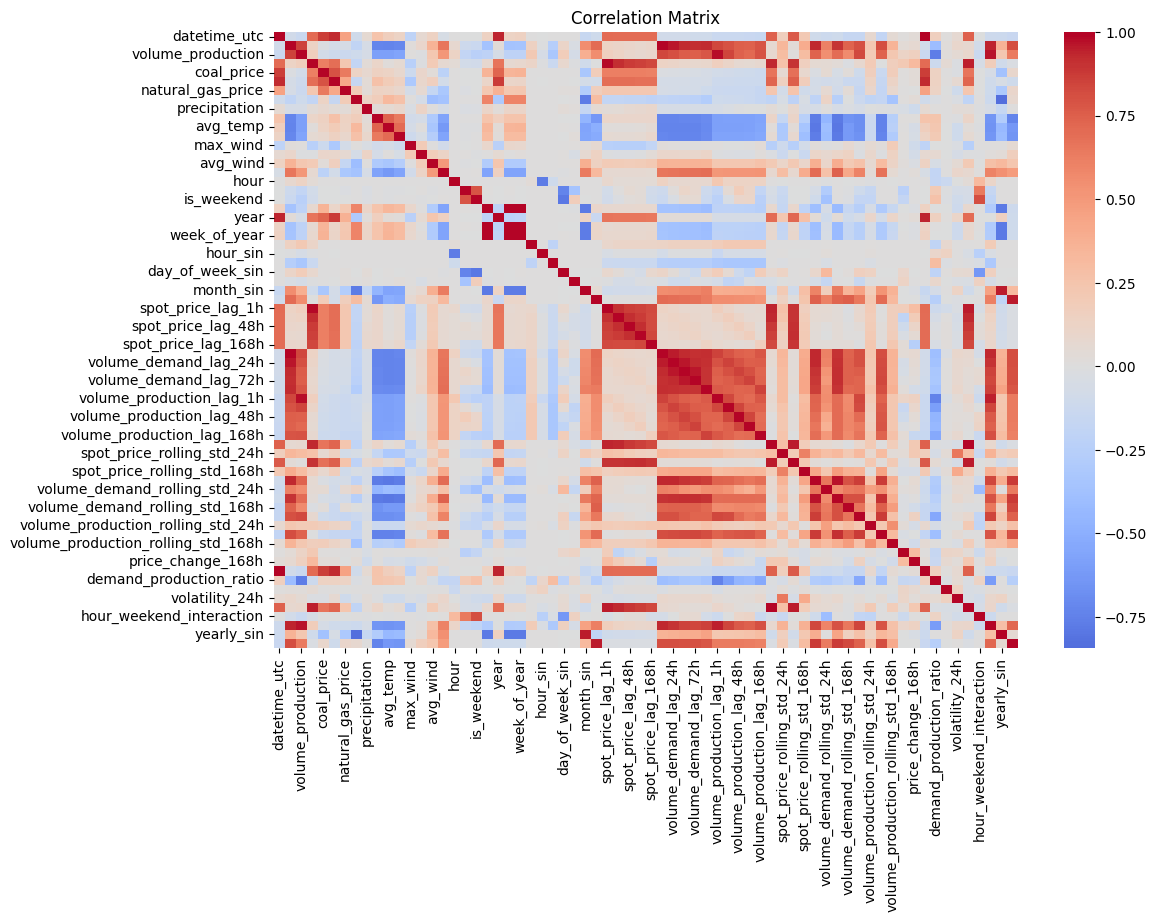

In [36]:
''' multivariate time series forecasting dataset'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from flaml import AutoML
from flaml.ml import sklearn_metric_loss_score
import seaborn as sns
from IPython.display import display
import pickle
from datetime import datetime

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

def transform_hydro_data(df):
    # Melt the dataframe
    melted = df.reset_index().melt(id_vars=['Uke'], var_name='Year', value_name='Fill_Level')
    
    # Convert 'Year' to string and remove ' %' if present
    melted['Year'] = melted['Year'].astype(str).str.replace(' %', '', regex=False)
    
    # Filter out non-year columns and rows with NaN values
    melted = melted[melted['Year'].str.isnumeric()]
    melted = melted.dropna(subset=['Fill_Level'])
    
    # Create date column (set to Monday of each week)
    melted['Date'] = pd.to_datetime(melted['Year'].astype(int).astype(str) + '-W' + 
                                  melted['Uke'].astype(str) + '-1', format='%Y-W%W-%w')
    
    # Group by Date and take the mean of Fill_Level to handle duplicates
    result = melted.groupby('Date')['Fill_Level'].mean().reset_index()
    
    # Sort by date
    result = result.sort_values('Date')
    
    return result

# Load and preprocess the dataset
df = pd.read_csv('Datasets/data_NO2.csv', sep=';', parse_dates=['datetime_utc'])
df = df.set_index('datetime_utc')
df.index = df.index.tz_localize(None)
df = df.resample('H').ffill()
df = df.bfill()
df = df.reset_index()

# Load external datasets
# Coal prices
coal = pd.read_csv("Datasets/coalspotprices.csv", index_col=0)
coal["Date"] = pd.to_datetime(coal["Date"])
coal.set_index("Date", inplace=True)
coal = coal[["Close"]].rename(columns={"Close": "coal_price"})

# Crude oil prices
crude_oil = pd.read_excel("Datasets/crudeoilspotprices.xls", index_col=0)
crude_oil.rename(columns={"Europe Brent Spot Price FOB (Dollars per Barrel)": "crude_oil_price"}, inplace=True)

# Natural gas prices
natural_gas = pd.read_csv("Datasets/gasspotprices.csv", parse_dates=['DATE'], index_col='DATE')
natural_gas['DHHNGSP'] = pd.to_numeric(natural_gas['DHHNGSP'], errors='coerce')
natural_gas.interpolate(method="linear", inplace=True)
natural_gas.rename(columns={"DHHNGSP": "natural_gas_price"}, inplace=True)

# Hydro levels
hydro = pd.read_excel("Datasets/hydrolevelsNO2.xlsx", index_col=0)
hydro_transformed = transform_hydro_data(hydro)
hydro_transformed.set_index('Date', inplace=True)
hydro_transformed.rename(columns={'Fill_Level': 'hydro_level'}, inplace=True)

# Weather data
weather1 = pd.read_csv("Datasets/NO2Weatherdata.csv", sep=";", decimal=",")
weather2 = pd.read_csv("Datasets/NO2Weatherdata2.csv", sep=";", decimal=",")

# Process weather data
weather1['Tid(norsk normaltid)'] = pd.to_datetime(weather1['Tid(norsk normaltid)'], format='%d.%m.%Y')
weather2['Tid(norsk normaltid)'] = pd.to_datetime(weather2['Tid(norsk normaltid)'], format='%d.%m.%Y')
weather = pd.merge(weather1, weather2, on=["Navn", "Stasjon", "Tid(norsk normaltid)"], how='outer')

# Rename weather columns
weather.rename(columns={
    'Tid(norsk normaltid)': 'Date',
    'Nedbør (døgn)': 'precipitation',
    'Maksimumstemperatur (døgn)': 'max_temp',
    'Middeltemperatur (døgn)': 'avg_temp',
    'Minimumstemperatur (døgn)': 'min_temp',
    'Høyeste middelvind (døgn)': 'max_wind',
    'Høyeste vindkast (døgn)': 'max_gust',
    'Middel av middelvind fra hovedobs. (døgn)': 'avg_wind',
    'Snødybde': 'snow_depth'
}, inplace=True)

# Process weather numeric columns
numeric_columns = ['precipitation', 'max_temp', 'avg_temp', 'min_temp', 
                  'max_wind', 'max_gust', 'avg_wind', 'snow_depth']
for col in numeric_columns:
    weather[col] = pd.to_numeric(weather[col].replace('-', pd.NA), errors='coerce')

# Group weather by date and calculate means
weather_avg = weather.groupby('Date')[numeric_columns].mean()
weather_avg = weather_avg.sort_index().ffill().bfill()

# Create hourly index
start_date = df['datetime_utc'].min()
end_date = df['datetime_utc'].max()
hourly_index = pd.date_range(start=start_date, end=end_date, freq='H')

# Resample all external data to hourly frequency with interpolation
coal = coal.reindex(coal.index.union(hourly_index)).interpolate(method='linear').reindex(hourly_index)
crude_oil = crude_oil.reindex(crude_oil.index.union(hourly_index)).interpolate(method='linear').reindex(hourly_index)
natural_gas = natural_gas.reindex(natural_gas.index.union(hourly_index)).interpolate(method='linear').reindex(hourly_index)
hydro_transformed = hydro_transformed.reindex(hydro_transformed.index.union(hourly_index)).interpolate(method='linear').reindex(hourly_index)
weather_avg = weather_avg.reindex(weather_avg.index.union(hourly_index)).interpolate(method='linear').reindex(hourly_index)

# Merge external data with main dataframe
df = df.set_index('datetime_utc')
df = pd.concat([
    df,
    coal,
    crude_oil,
    natural_gas,
    hydro_transformed,
    weather_avg
], axis=1)
df = df.reset_index()
df = df.rename(columns={'index': 'datetime_utc'})  # Add this line to fix the column name

# Add time-based features
df['hour'] = df['datetime_utc'].dt.hour
df['day_of_week'] = df['datetime_utc'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['month'] = df['datetime_utc'].dt.month
df['year'] = df['datetime_utc'].dt.year
df['day_of_year'] = df['datetime_utc'].dt.dayofyear
df['week_of_year'] = df['datetime_utc'].dt.isocalendar().week
df['is_peak_hour'] = df['hour'].isin([6, 7, 8, 16, 17, 18]).astype(int)

# Add cyclical encoding
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Add lag features
for col in ['spot_price', 'volume_demand', 'volume_production']:
    for lag in [1, 24, 48, 72, 168]:
        df[f'{col}_lag_{lag}h'] = df[col].shift(lag)

# Add rolling statistics
for col in ['spot_price', 'volume_demand', 'volume_production']:
    for window in [24, 168]:
        df[f'{col}_rolling_mean_{window}h'] = df[col].rolling(window=window).mean()
        df[f'{col}_rolling_std_{window}h'] = df[col].rolling(window=window).std()

# Add additional features
df['price_change_24h'] = df['spot_price'] - df['spot_price_lag_24h']
df['price_change_168h'] = df['spot_price'] - df['spot_price_lag_168h']
df['days_since_start'] = (df['datetime_utc'] - df['datetime_utc'].min()).dt.total_seconds() / (24 * 3600)
df['demand_production_ratio'] = df['volume_demand'] / df['volume_production']
df['returns'] = df['spot_price'].pct_change()
df['volatility_24h'] = df['returns'].rolling(window=24).std()
df['price_ewma'] = df['spot_price'].ewm(span=24, adjust=False).mean()
df['hour_weekend_interaction'] = df['hour'] * df['is_weekend']
df['demand_production_interaction'] = df['volume_demand'] * df['volume_production']
df['yearly_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
df['yearly_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)

# Drop rows with NaN values
df.dropna(inplace=True)

display(df.head(100))

# Correlation matrix with no numbers using seaborn
corr_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

# Split data into train and test
num_samples = df.shape[0]
time_horizon = 168  # Predict for the next 168 hours (1 week)
split_idx = num_samples - time_horizon
train_df = df[:split_idx]
test_df = df[split_idx:]

# Select features for testing (excluding datetime_utc and target variable)
feature_cols = [col for col in df.columns if col not in ['datetime_utc', 'spot_price']]
X_test = test_df[['datetime_utc'] + feature_cols]
y_test = test_df['spot_price']



In [37]:
# # Initialize AutoML
# automl = AutoML()

# # Configure settings
# settings = {
#     # "time_budget": 1500,  # increased time budget due to more features
#     # "max_iter": 2,
#     "metric": "mae",
#     "task": "ts_forecast",
#     "log_file_name": f"logs/FLAML_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log",
#     "eval_method": "holdout",
#     "log_type": "all",
#     "label": "spot_price",
#     "period": time_horizon,
#     "ensemble": True,
#     "estimator_list": ['extra_tree', 'prophet', 'arima', 'sarimax', 'holt-winters', 'lgbm', 'xgboost', 'xgb_limitdepth'],
# }

# # Fit the model
# automl.fit(dataframe=train_df, **settings)

# print(automl.best_estimator)
# print(automl.best_config)

# # Make predictions and evaluate
# y_pred = automl.predict(X_test)
# mae = sklearn_metric_loss_score('mae', y_true=y_test, y_predict=y_pred)
# print('MAE =', mae)

# # Plot results
# plt.figure(figsize=(12, 6))
# plt.plot(X_test["datetime_utc"], y_test, label="Actual Spot Price")
# plt.plot(X_test["datetime_utc"], y_pred, label="FLAML Forecast")
# plt.xlabel("Date")
# plt.ylabel("Spot Price")
# plt.title("Spot Price Forecast with Feature Engineering")
# plt.legend()
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# # Save just the best model with timestamp
# from datetime import datetime
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# model_filename = f"best_model_{timestamp}.pkl"
# with open(model_filename, "wb") as f:
#     pickle.dump(automl.model, f, pickle.HIGHEST_PROTOCOL)

Error loading previous configurations: Expecting value: line 1 column 1 (char 0)
[flaml.automl.logger: 10-27 20:58:07] {1728} INFO - task = ts_forecast
[flaml.automl.logger: 10-27 20:58:07] {1739} INFO - Evaluation method: holdout
[flaml.automl.logger: 10-27 20:58:07] {1838} INFO - Minimizing error metric: mae
[flaml.automl.logger: 10-27 20:58:07] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost', 'xgb_limitdepth', 'extra_tree', 'holt-winters']
[flaml.automl.logger: 10-27 20:58:07] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 10-27 20:59:25] {2393} INFO - Estimated sufficient time budget=784837s. Estimated necessary time budget=785s.
[flaml.automl.logger: 10-27 20:59:25] {2442} INFO -  at 79.1s,	estimator lgbm's best error=19.6215,	best estimator lgbm's best error=19.6215
[flaml.automl.logger: 10-27 20:59:25] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 10-27 21:04:51] {2442} INFO -  at 404.7s,	estimator lgbm's best er

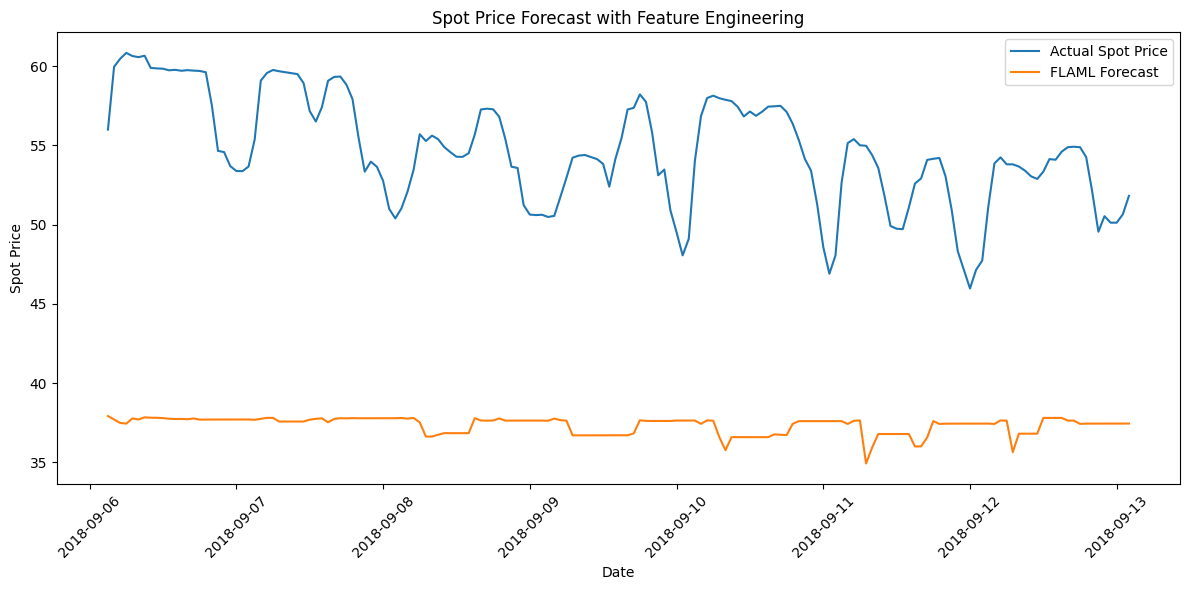

In [38]:
# Initialize AutoML
automl = AutoML()

# Load previous best configurations if they exist
CONFIG_FILE = 'flaml_best_configs.json'

import os
import json
starting_points = None
if os.path.exists(CONFIG_FILE):
    try:
        with open(CONFIG_FILE, 'r') as f:
            starting_points = json.load(f)
        print("Loaded previous best configurations")
    except Exception as e:
        print(f"Error loading previous configurations: {e}")

# Configure settings
settings = {
    "time_budget": 300,  # increased time budget due to more features
    # "max_iter": 2,
    "metric": "mae",
    "task": "ts_forecast",
    "log_file_name": f"logs/FLAML_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log",
    "eval_method": "holdout",
    "log_type": "all",
    "label": "spot_price",
    "period": time_horizon,
    "ensemble": True,
    "estimator_list": ['lgbm', 'xgboost', 'xgb_limitdepth', 'extra_tree', 'holt-winters'], # 'prophet', 'arima', 'sarimax', 
    "time_series_split": True,  # Ensure time series cross-validation
    "split_type": "time",  # Enforce time-based splitting
    "starting_points": starting_points  # Use previous configurations if available
}

# Fit the model
automl.fit(dataframe=train_df, **settings)

# Save the best configurations for next run
try:
    with open(CONFIG_FILE, 'w') as f:
        json.dump(automl.best_config_per_estimator, f)
    print("Saved best configurations for next run")
except Exception as e:
    print(f"Error saving configurations: {e}")

# Print results
print('Best Estimator:', automl.best_estimator)
print('Best Config:', automl.best_config)

# Make predictions and evaluate
y_pred = automl.predict(X_test)
mae = sklearn_metric_loss_score('mae', y_true=y_test, y_predict=y_pred)
print('MAE =', mae)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(X_test["datetime_utc"], y_test, label="Actual Spot Price")
plt.plot(X_test["datetime_utc"], y_pred, label="FLAML Forecast")
plt.xlabel("Date")
plt.ylabel("Spot Price")
plt.title("Spot Price Forecast with Feature Engineering")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save just the best model with timestamp
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f"best_model_{timestamp}.pkl"
with open(model_filename, "wb") as f:
    pickle.dump(automl.model, f, pickle.HIGHEST_PROTOCOL)

In [39]:
import os
os.system('say "Wallah min bror! Din maskinlæringsmodell er klar. In god may your predictions be goated and the MAE low!"')

0